In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import random
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
!pip install cairocffi
import cairocffi as cairo
import struct
from struct import unpack

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 4.5 MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.3.0-py3-none-any.whl size=89668 sha256=f8fd88fa716e22332c3cb5f9964808750004f992e8a7a34397936fae258a04ec
  Stored in directory: /root/.cache/pip/wheels/4e/ca/e1/5c8a9692a27f639a07c949044bec943f26c81cd53d3805319f
Successfully built cairocffi


In [ ]:
# Env vars
torch.use_deterministic_algorithms(False)

# Const vars
LOAD_PATH = '/content/drive/My Drive/Fourier/Saved Models/CNN.pt'
RAND_SEED = 0
DEVICE = "cpu"

IMG_SIDE = 28
NUM_CLASSES = 343
EPOCHS = 10
LEARNING_RATE = 0.001
BATCH_SIZE = 512
LOSS_FN = nn.CrossEntropyLoss()

In [ ]:
# convert raw vector image to single raster image
def vector_to_raster(vector_image, side=IMG_SIDE, line_diameter=16, padding=96, bg_color=(0,0,0), fg_color=(1,1,1)):
  """
  padding and line_diameter are relative to the original 256x256 image.
  """
  
  original_side = 256.
  
  surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, side, side)
  ctx = cairo.Context(surface)
  ctx.set_antialias(cairo.ANTIALIAS_BEST)
  ctx.set_line_cap(cairo.LINE_CAP_ROUND)
  ctx.set_line_join(cairo.LINE_JOIN_ROUND)
  ctx.set_line_width(line_diameter)

  # scale to match the new size
  # add padding at the edges for the line_diameter
  # and add additional padding to account for antialiasing
  total_padding = padding * 2. + line_diameter
  new_scale = float(side) / float(original_side + total_padding)
  ctx.scale(new_scale, new_scale)
  ctx.translate(total_padding / 2., total_padding / 2.)
      
  bbox = np.hstack(vector_image).max(axis=1)
  offset = ((original_side, original_side) - bbox) / 2.
  offset = offset.reshape(-1,1)
  centered = [stroke + offset for stroke in vector_image]

  # clear background
  ctx.set_source_rgb(*bg_color)
  ctx.paint()

  # draw strokes, this is the most cpu-intensive part
  ctx.set_source_rgb(*fg_color)     
  for xv, yv in centered:   
    ctx.move_to(xv[0], yv[0])
    for x, y in zip(xv, yv):
        ctx.line_to(x, y)
    ctx.stroke()

  data = surface.get_data()
  raster = np.copy(np.asarray(data)[::4]).reshape(28, 28)
  return raster

# Define transformation(s) to be applied to dataset-
transforms_norm = T.Compose(
      [
          T.ToTensor(), # scales integer inputs in the range [0, 255] into the range [0.0, 1.0]
          T.Normalize(mean=(0.138), std=(0.296)) # Quickdraw mean and stdev (35.213, 75.588), divided by 255
          
      ]
  )

# transform functions - take sketch image, return torch tensor of descriptors
def transform(vector_img, is_test):
  raster = vector_to_raster(vector_img)
  raster = transforms_norm(raster)

  # add rotations and translations at test time
  if is_test: 
    angle = random.random()*60 - 30
    deltaX = random.randint(-3, 3)
    deltaY = random.randint(-3, 3)

    raster = T.functional.affine(raster, angle, [deltaX, deltaY], 1, 0,
                                 interpolation=T.InterpolationMode.BILINEAR)
  return raster

# helper method to find class based on imgset index
def find_class(idx, num_list):
  class_id = 0
  sum = num_list[class_id]
  while idx >= sum:
    class_id += 1
    sum += num_list[class_id]
  return class_id

# deterministic worker re-seeding
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

# custom dataset for quickdraw
class QuickdrawDataset(Dataset):
  def __init__(self, imgs, nums, is_test):
    self.imgs = imgs
    self.nums = nums
    self.len = sum(nums)
    self.is_test = is_test

  def __len__(self):
    return self.len

  def __getitem__(self, idx):
    img = self.imgs[idx]
    x = transform(img, self.is_test)
    y = find_class(idx, self.nums)
    return x, y


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv2 = nn.Conv2d(64, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.conv4 = nn.Conv2d(64, 64, 3)
        self.maxpool = nn.MaxPool2d(2) 
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(64 * 4 * 4, 384)
        self.head = nn.Linear(384, NUM_CLASSES)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        return self.head(x)


def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train() # put the model in train mode
    total_loss = 0
    total_correct = 0
    # for each batch in the training set compute loss and update model parameters
    for batch, (x, y) in enumerate(dataloader):
      x, y = x.to(DEVICE), y.to(DEVICE)
      # Compute prediction and loss
      out = model(x)
      loss = loss_fn(out, y)

      # Backpropagation to update model parameters
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # print current training metrics for user
      y, out, loss = y.to("cpu"), out.to("cpu"), loss.to("cpu")
      loss_val = loss.item()
      if batch % 100 == 0:
          current = (batch + 1) * BATCH_SIZE
          print(f"loss: {loss_val:>7f}  [{current:>5d}/{size:>5d}]")

      pred = out.argmax(dim=1, keepdim=True)
      correct = pred.eq(y.view_as(pred)).sum().item()
      total_correct += correct
      total_loss += loss_val
      # print(f"train loss: {loss_val:>7f}   train accuracy: {correct / BATCH_SIZE:>7f}   [batch: {batch + 1:>3d}/{(size // BATCH_SIZE) + 1:>3d}]")      
    print(f"\nepoch avg train loss: {total_loss / ((size // BATCH_SIZE) + 1):>7f}   epoch avg train accuracy: {total_correct / size:>7f}")
      
def eval_loop(dataloader, model):
  model.eval()
  size = len(dataloader.dataset)
  with torch.no_grad():
    total_correct = 0
    for x, y in dataloader:
      x, y = x.to(DEVICE), y.to(DEVICE)
      out = model(x)
      y, out = y.to("cpu"), out.to("cpu")
      pred = out.argmax(dim=1, keepdim=True)
      total_correct += pred.eq(y.view_as(pred)).sum().item()

    accuracy = total_correct / size
    print(f"test accuracy: {accuracy:>7f}")


In [ ]:
# define methods for unpacking Quickdraw .bin files
def unpack_drawing(file_handle):
  file_handle.read(15)
  n_strokes, = unpack('H', file_handle.read(2))
  image = []
  for i in range(n_strokes):
      n_points, = unpack('H', file_handle.read(2))
      fmt = str(n_points) + 'B'
      x = unpack(fmt, file_handle.read(n_points))
      y = unpack(fmt, file_handle.read(n_points))
      image.append((x, y))

  return image


def unpack_drawings(filename):
  imageset = []
  with open(filename, 'rb') as f:
      while True:
          try:
              imageset.append(unpack_drawing(f))
          except struct.error:
              break
  return imageset

train_dir = '/content/drive/My Drive/Fourier/Quickdraw Dataset Small/Train/'
test_dir = '/content/drive/My Drive/Fourier/Quickdraw Dataset Small/Test/'
train_imgs = []
test_imgs = []
train_nums = []
test_nums = []
list_of_classes = ["The Eiffel Tower", "The Great Wall of China", "The Mona Lisa",
                   "aircraft carrier", "airplane", "alarm clock", "ambulance", 
                   "angel", "ant", "anvil", "apple", "arm", "asparagus", "axe", 
                   "backpack", "banana", "bandage", "barn", "baseball bat", 
                   "baseball", "basket", "basketball", "bathtub", "beach", "bear", 
                   "beard", "bed", "bee", "belt", "bench", "bicycle", "binoculars", 
                   "bird", "birthday cake", "blackberry", "blueberry", "book", 
                   "boomerang", "bottlecap", "bowtie", "bracelet", "brain", 
                   "bread", "bridge", "broccoli", "broom", "bucket", "bulldozer", 
                   "bus", "bush", "butterfly", "cactus", "cake", "calculator", 
                   "calendar", "camel", "camera", "camouflage", "campfire", 
                   "candle", "cannon", "canoe", 'car', 'carrot', "castle", "cat", "ceiling fan", 
                   "cell phone", "cello", "chair", "chandelier", "church", 
                   "circle", "clarinet", "clock", "cloud", "coffee cup", 
                   "compass", "computer", "cookie", "cooler", "couch", "cow",
                   "crab", "crayon", "crocodile", "crown", "cruise ship", 
                   "cup", "diamond", "dishwasher", "diving board", "dog", 
                   "dolphin", "donut", "door", "dragon", "dresser", "drill", 
                   "drums", "duck", "dumbbell", "ear", "elbow", "elephant", 
                   "envelope", "eraser", "eye", "eyeglasses", "face", "fan",
                   "feather", "fence", "finger", "fire hydrant", "fireplace",
                   "firetruck", "fish", "flamingo", "flashlight", "flip flops", 
                   "floor lamp", "flower", "flying saucer", "foot", "fork", 
                   "frog", "frying pan", "garden hose", "garden", "giraffe", 
                   "goatee", "golf club", "grapes", "grass", "guitar", 
                   "hamburger", "hammer", "hand", "harp", "hat", "headphones", 
                   "hedgehog", "helicopter", "helmet", "hexagon", "hockey puck", 
                   "hockey stick", "horse", "hospital", "hot air balloon", 
                   "hot dog", "hot tub", "hourglass", "house plant", "house", 
                   "hurricane", "ice cream", "jacket", "jail", "kangaroo", 
                   "key", "keyboard", "knee", "knife", "ladder", "lantern", 
                   "laptop", "leaf", "leg", "light bulb", "lighter", "lighthouse",
                   "lightning", "line", "lion", "lipstick", "lobster", "lollipop",
                   "mailbox", "map", "marker", "matches", "megaphone", "mermaid", 
                   "microphone", "microwave", "monkey", "moon", "mosquito", 
                   "motorbike", "mountain", "mouse", "moustache", "mouth", "mug",
                   "mushroom", "nail", "necklace", "nose", "ocean", "octagon", 
                   "octopus", "onion", "oven", "owl", "paint can", "paintbrush", 
                   "palm tree", "panda", "pants", "paper clip", "parachute", 
                   "parrot", "passport", "peanut", "pear", "peas", "pencil", 
                   "penguin", "piano", "pickup truck", "picture frame", "pig", 
                   "pillow", "pineapple", "pizza", "pliers", "police car", 
                   "pond", "pool", "popsicle", "postcard", "potato", 
                   "power outlet", "purse", "rabbit", "raccoon", "radio", 
                   "rain", 'rainbow', 'rake', 'remote control', 'rhinoceros', 
                   'rifle', 'river', 'roller coaster', 'rollerskates', 
                   'sailboat', 'sandwich', 'saw', 'saxophone', 'school bus', 
                   'scissors', 'scorpion', 'screwdriver', 'sea turtle', 
                   'see saw', 'shark', 'sheep', 'shoe', 'shorts', 'shovel', 
                   'sink', 'skateboard', 'skull', 'skyscraper', 'sleeping bag', 
                   'smiley face', 'snail', 'snake', 'snorkel', 'snowflake', 
                   'snowman', 'soccer ball', 'sock', 'speedboat', 'spider', 
                   'spoon', 'spreadsheet', 'square', 'squiggle', 'squirrel', 
                   'stairs', 'star', 'steak', 'stereo', 'stethoscope', 'stitches', 
                   'stop sign', 'stove', 'strawberry', 'streetlight', 
                   'string bean', 'submarine', 'suitcase', 'sun', 'swan', 
                   'sweater', 'swing set', 'sword', 'syringe', 't-shirt', 
                   'table', 'teapot', 'teddy-bear', 'telephone', 'television', 
                   'tennis racquet', 'tent', 'tiger', 'toaster', 'toe', 'toilet', 
                   'tooth', 'toothbrush', 'toothpaste', 'tornado', 'tractor', 
                   'traffic light', 'train', 'tree', 'triangle', 'trombone', 
                   'truck', 'trumpet', 'umbrella', 'underwear', 'van', 'vase', 'violin', 
                   'washing machine', 'watermelon', 'waterslide', 'whale', 
                   'wheel', 'windmill', 'wine bottle', 'wine glass', 'wristwatch', 
                   'yoga', 'zebra', 'zigzag']

In [ ]:
# load dataset
for item in list_of_classes:
  # train_folder = train_dir + item + '.bin'
  test_folder = test_dir + item + '.bin'
  # train_drawings = unpack_drawings(train_folder)
  # train_imgs += train_drawings
  # train_nums.append(len(train_drawings))
  test_drawings = unpack_drawings(test_folder)
  test_imgs += test_drawings
  test_nums.append(len(test_drawings))

test accuracy: 0.589270


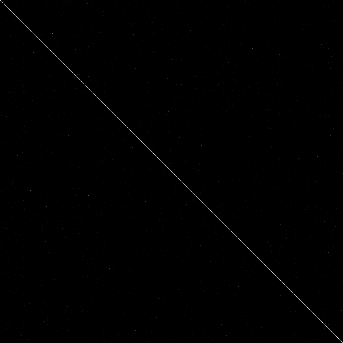

aircraft carrier accuracy 0.07
crayon accuracy 0.11
pool accuracy 0.13
dog accuracy 0.15
frog accuracy 0.16
string bean accuracy 0.2
camouflage accuracy 0.22
garden hose accuracy 0.22
The Great Wall of China accuracy 0.23
raccoon accuracy 0.23
cooler accuracy 0.26
marker accuracy 0.27
steak accuracy 0.29
squiggle accuracy 0.29
bird accuracy 0.29
bear accuracy 0.3
dragon accuracy 0.3
bus accuracy 0.3
hurricane accuracy 0.31
firetruck accuracy 0.32
birthday cake accuracy 0.32
paintbrush accuracy 0.34
tiger accuracy 0.34
parrot accuracy 0.34
lobster accuracy 0.34
roller coaster accuracy 0.34
matches accuracy 0.35
mouse accuracy 0.35
speedboat accuracy 0.36
clarinet accuracy 0.36
trombone accuracy 0.36
dishwasher accuracy 0.37
blueberry accuracy 0.37
truck accuracy 0.37
paint can accuracy 0.37
pond accuracy 0.37
toaster accuracy 0.38
mosquito accuracy 0.38
eraser accuracy 0.38
toothpaste accuracy 0.38
pliers accuracy 0.38
bottlecap accuracy 0.39
mug accuracy 0.39
guitar accuracy 0.4
yoga a

In [ ]:
DEVICE = "cpu"
torch.manual_seed(RAND_SEED)
random.seed(RAND_SEED)
g = torch.Generator()
g.manual_seed(RAND_SEED)

def get_confusion_mat(dataloader, model):
  model.eval()
  size = len(dataloader.dataset)
  conf_mat = np.zeros((NUM_CLASSES, NUM_CLASSES))
  with torch.no_grad():
    total_correct = 0
    for x, y in dataloader:
      x, y = x.to(DEVICE), y.to(DEVICE)
      out = model(x)
      y, out = y.to("cpu"), out.to("cpu")
      pred = out.argmax(dim=1, keepdim=True)
      y = y.view_as(pred)
      total_correct += pred.eq(y).sum().item()
      y, pred = y.numpy(), pred.numpy()
      indices = np.concatenate((y, pred), axis=1)
      for i in range(indices.shape[0]):
        conf_mat[indices[i, 0], indices[i, 1]] += 1

    accuracy = total_correct / size
    print(f"test accuracy: {accuracy:>7f}")
    return conf_mat

eval_data = QuickdrawDataset(test_imgs, test_nums, is_test=False)
eval_loader = DataLoader(eval_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)

model = CNN()
checkpoint = torch.load(LOAD_PATH, map_location=torch.device(DEVICE))
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE)

random.seed(RAND_SEED)
conf_mat = get_confusion_mat(dataloader=eval_loader,model=model)
conf_mat_norm = conf_mat * (255 / 100)
cv2_imshow(conf_mat_norm)

diag = np.diagonal(conf_mat)
sums = np.asarray(test_nums)
accuracies = diag / sums
acc_sorted_idxs = np.argsort(accuracies)
for i in range(NUM_CLASSES):
  print(list_of_classes[acc_sorted_idxs[i]] + " accuracy " + str(accuracies[acc_sorted_idxs[i]]))

In [ ]:
# seed RNGs
torch.manual_seed(RAND_SEED)
random.seed(RAND_SEED)

# create datasets
# train_data = QuickdrawDataset(train_imgs, train_nums, is_test=False)
eval_data = QuickdrawDataset(test_imgs, test_nums, is_test=False)
# test_data = QuickdrawDataset(test_imgs, test_nums, is_test=True)

# create dataloaders
g = torch.Generator()
g.manual_seed(RAND_SEED)
# train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, worker_init_fn=seed_worker, generator=g)
eval_loader = DataLoader(eval_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)
# test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)

# init model and optimizer
model = CNN()
checkpoint = torch.load(SAVE_PATH, map_location=torch.device(DEVICE))
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE)
# optim = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# optim.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# epoch = 0

# train for EPOCHS number of epochs then evaluate on test data with affine transformations
# eval_loop(dataloader=test_loader,model=model)
# for i in range(EPOCHS):
#     print("Epoch " + str(i + 1) + "\n")
#     train_loop(dataloader=train_loader,model=model,loss_fn=LOSS_FN,optimizer=optim)
#     # eval_loop(dataloader=eval_loader,model=model)
#     torch.save({
#                 'epoch': i + 1,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optim.state_dict()
#                 }, SAVE_PATH)
#     print("\n-------------------------------\n")
random.seed(RAND_SEED)
eval_loop(dataloader=eval_loader,model=model)

test accuracy: 0.589270


In [ ]:
# seed RNGs
torch.manual_seed(RAND_SEED)
random.seed(RAND_SEED)

# create datasets
train_data = QuickdrawDataset(train_imgs, train_nums, is_test=False)
# eval_data = QuickdrawDataset(test_imgs, test_nums, is_test=False)
test_data = QuickdrawDataset(test_imgs, test_nums, is_test=True)

# create dataloaders
g = torch.Generator()
g.manual_seed(RAND_SEED)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, worker_init_fn=seed_worker, generator=g)
# eval_loader = DataLoader(eval_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)

# init model and optimizer
model = CNN()
# checkpoint = torch.load(SAVE_PATH, map_location=torch.device(DEVICE))
# model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE)
optim = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# optim.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
epoch = 0

# train for EPOCHS number of epochs then evaluate on test data with affine transformations
# eval_loop(dataloader=test_loader,model=model)
for i in range(EPOCHS):
    print("Epoch " + str(i + 1) + "\n")
    train_loop(dataloader=train_loader,model=model,loss_fn=LOSS_FN,optimizer=optim)
    # eval_loop(dataloader=eval_loader,model=model)
    torch.save({
                'epoch': i + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optim.state_dict()
                }, SAVE_PATH)
    print("\n-------------------------------\n")
random.seed(RAND_SEED)
eval_loop(dataloader=test_loader,model=model)

Epoch 1

loss: 5.840163  [  512/342985]
loss: 3.840167  [51712/342985]
loss: 3.397365  [102912/342985]
loss: 2.924365  [154112/342985]
loss: 2.547597  [205312/342985]
loss: 2.525334  [256512/342985]
loss: 2.452715  [307712/342985]

epoch avg train loss: 3.104376   epoch avg train accuracy: 0.334615

-------------------------------

Epoch 2

loss: 2.345467  [  512/342985]
loss: 2.302943  [51712/342985]
loss: 2.167568  [102912/342985]
loss: 2.223393  [154112/342985]
loss: 2.134763  [205312/342985]
loss: 1.989801  [256512/342985]
loss: 2.081902  [307712/342985]

epoch avg train loss: 2.130624   epoch avg train accuracy: 0.504760

-------------------------------

Epoch 3

loss: 1.949772  [  512/342985]
loss: 2.098809  [51712/342985]
loss: 1.808567  [102912/342985]
loss: 1.907323  [154112/342985]
loss: 2.034228  [205312/342985]
loss: 1.803040  [256512/342985]
loss: 1.884101  [307712/342985]

epoch avg train loss: 1.883309   epoch avg train accuracy: 0.555094

-------------------------------

In [ ]:
for i in range(10, 20):
    print("Epoch " + str(i + 1) + "\n")
    train_loop(dataloader=train_loader,model=model,loss_fn=LOSS_FN,optimizer=optim)
    # eval_loop(dataloader=eval_loader,model=model)
    torch.save({
                'epoch': i + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optim.state_dict()
                }, SAVE_PATH)
    print("\n-------------------------------\n")
random.seed(RAND_SEED)
eval_loop(dataloader=test_loader,model=model)

Epoch 11

loss: 1.470745  [  512/342985]
loss: 1.244196  [51712/342985]
loss: 1.469500  [102912/342985]
loss: 1.450875  [154112/342985]
loss: 1.485562  [205312/342985]
loss: 1.293524  [256512/342985]
loss: 1.437426  [307712/342985]

epoch avg train loss: 1.357390   epoch avg train accuracy: 0.660831

-------------------------------

Epoch 12

loss: 1.254562  [  512/342985]
loss: 1.277707  [51712/342985]
loss: 1.454326  [102912/342985]
loss: 1.539767  [154112/342985]
loss: 1.357604  [205312/342985]
loss: 1.296664  [256512/342985]
loss: 1.436981  [307712/342985]

epoch avg train loss: 1.324578   epoch avg train accuracy: 0.667370

-------------------------------

Epoch 13

loss: 1.436270  [  512/342985]
loss: 1.119371  [51712/342985]
loss: 1.256000  [102912/342985]
loss: 1.069739  [154112/342985]
loss: 1.213586  [205312/342985]
loss: 1.343170  [256512/342985]
loss: 1.272454  [307712/342985]

epoch avg train loss: 1.296623   epoch avg train accuracy: 0.673187

----------------------------